In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
os.chdir('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
os.chdir(motionbert_root)

### Load h36m dataset

In [3]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [4]:
print(h36m_3d_world._data.keys())
print(h36m_3d_world._data['S5'].keys())
print(h36m_3d_world._data['S5']['Waiting 1'].keys())
print(h36m_3d_world._data['S5']['Waiting 1']['positions'].shape)

dict_keys(['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'])
dict_keys(['Waiting 1', 'Sitting', 'Waiting 2', 'Smoking', 'WalkTogether 1', 'Discussion 2', 'Greeting 1', 'Directions 2', 'Phoning', 'Phoning 1', 'Smoking 1', 'Greeting 2', 'WalkTogether', 'Sitting 1', 'SittingDown', 'SittingDown 1', 'Discussion 3', 'Directions 1', 'Purchases', 'Walking 1', 'WalkDog 1', 'Walking', 'Eating', 'Photo 2', 'Posing', 'Posing 1', 'WalkDog', 'Photo', 'Purchases 1', 'Eating 1'])
dict_keys(['positions', 'cameras'])
(4517, 17, 3)


### Get bbox information of h36m and save it as pkl

In [76]:
# subject = 'S5'
# action = 'Waiting 1'
# camera_id = '54138969'
dict_save_path = '/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/bbox_info.pkl'
if os.path.exists(dict_save_path):
    data_dict = readpkl(dict_save_path)
else:
    data_dict = {}
    for subject in h36m_3d_world._data.keys():
        data_dict[subject] = {}
        print(subject)
        save_video = False
        save_fig = True
        fig = plt.figure(0)
        fig.clear()
        #ax = axes_3d(fig, loc=121)
        ax2 = axes_2d(fig, loc=111, W=1000, H=1000)

        max_left_list = []
        max_right_list = []
        max_top_list = []
        max_bottom_list = []
        mean_center_list = []
        for action in tqdm(h36m_3d_world._data[subject].keys()):
            data_dict[subject][action] = {}
            pose3d_list = h36m_3d_world._data[subject][action]['positions']
            cam_info = h36m_3d_world._data[subject][action]['cameras']
            cam_param = get_cam_param(cam_info, subject, h36m_cam_param)
            for camera_id in cam_param.keys():
                data_dict[subject][action][camera_id] = {}
                #print(subject, action, camera_id)
                calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
                R = cam_param[camera_id]['ext']['R']
                t = np.array(cam_param[camera_id]['ext']['t'])/1000
                camera_param = {
                    'intrinsic': calibration_matrix,
                    'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
                }
                fx = camera_param['intrinsic'][0, 0]  
                fy = camera_param['intrinsic'][1, 1]  
                cx = camera_param['intrinsic'][0, 2]  
                cy = camera_param['intrinsic'][1, 2] 

                #frame_num = 0
                top_left_list = []
                bottom_right_list = []
                center_list = []
                if save_video:
                    save_folder = f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}'
                    if not os.path.exists(save_folder): os.makedirs(save_folder)
                    video_path = os.path.join(save_folder, f'check_bbox_{subject}_{action}_{camera_id}.mp4')
                    if os.path.exists(video_path): continue
                    videowriter = imageio.get_writer(video_path, fps=30)
                for frame_num in range(0, len(pose3d_list)):
                    world_3d = np.array(pose3d_list[frame_num])
                    trans = np.zeros(3)
                    rot = np.eye(3) # Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()
                    modified = world_3d.copy()
                    if trans is not None:
                        modified -= np.array([modified[0][0], modified[0][1], 0])
                        modified += np.array([trans[0], trans[1], 0])
                    if rot is not None:
                        modified = rotate_torso_by_R(modified, rot)
                    world_3d = modified

                    # world to camera
                    pos = copy.deepcopy(world_3d)
                    cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
                    cam_3d_hat = get_rootrel_pose(cam_3d)

                    # camera to image
                    box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
                    img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
                    bbox = get_bbox_from_pose2d(img_2d)

                    #clear_axes(ax2)
                    #draw_3d_pose(ax, world_3d)
                    #draw_2d_pose(ax2, img_2d)
                    #draw_bbox(ax2, bbox)
                    top_left_list.append(bbox[:2])
                    bottom_right_list.append(bbox[2:])
                    center_list.append((np.array(bbox[:2]) + np.array(bbox[2:]))/2)
                    # ax2.plot(bbox[0], bbox[1], 'kx')
                    # ax2.plot(bbox[2], bbox[3], 'kx')
                    # ax2.plot((bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2, 'kx')
                    if save_video:
                        canvas = FigureCanvas(fig)
                        canvas.draw()
                        image_from_plot = np.array(canvas.renderer._renderer)
                        image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
                        videowriter.append_data(image_from_plot)

                clear_axes(ax2)
                top_left_list = np.array(top_left_list)
                bottom_right_list = np.array(bottom_right_list)
                center_list = np.array(center_list)
                draw_trajectory(ax2, top_left_list, -1, recent=0, dim='2d')
                draw_trajectory(ax2, bottom_right_list, -1, recent=0, dim='2d')
                draw_trajectory(ax2, center_list, -1, recent=0, dim='2d')

                max_left = np.min(top_left_list[:, 0])
                max_top = np.min(top_left_list[:, 1])
                max_right = np.max(bottom_right_list[:, 0])
                max_bottom = np.max(bottom_right_list[:, 1])
                max_left_list.append(max_left)
                max_right_list.append(max_right)
                max_top_list.append(max_top)
                max_bottom_list.append(max_bottom)
                mean_center_list.append(np.mean(center_list, axis=0))
                ax2.plot(max_left, max_top, 'ro')
                ax2.plot(max_right, max_bottom, 'bx')
                draw_bbox(ax2, [max_left, max_top, max_right, max_bottom])

                data_dict[subject][action][camera_id]['top_left_list'] = top_left_list
                data_dict[subject][action][camera_id]['bottom_right_list'] = bottom_right_list
                data_dict[subject][action][camera_id]['center_list'] = center_list
                data_dict[subject][action][camera_id]['max_bbox'] = np.array([max_left, max_top, max_right, max_bottom]) # x1, y1, x2, y2
                

                if save_video:
                    canvas = FigureCanvas(fig)
                    canvas.draw()
                    image_from_plot = np.array(canvas.renderer._renderer)
                    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
                    videowriter.append_data(image_from_plot)
                    videowriter.close()
                #else:
                #    plt.show()
                if save_fig:
                    save_folder = f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}'
                    if not os.path.exists(save_folder): os.makedirs(save_folder)
                    fig_path = os.path.join(save_folder, f'check_bbox_area_{subject}_{action}_{camera_id}.png')
                    if os.path.exists(fig_path): continue
                    fig.savefig(fig_path)

                #break
            #break
        max_left_list = np.array(max_left_list)
        max_right_list = np.array(max_right_list)
        max_top_list = np.array(max_top_list)
        max_bottom_list = np.array(max_bottom_list)
        mean_center_list = np.array(mean_center_list)
        data_dict[subject]['max_left_list'] = max_left_list
        data_dict[subject]['max_right_list'] = max_right_list
        data_dict[subject]['max_top_list'] = max_top_list
        data_dict[subject]['max_bottom_list'] = max_bottom_list
        data_dict[subject]['mean_center_list'] = mean_center_list

        fig = plt.figure(1)
        fig.clear()
        ax = fig.add_subplot(111)
        ax.plot(max_left_list, max_top_list, 'ro', label='max left_top of bbox for each video')
        ax.plot(max_right_list, max_bottom_list, 'bx', label='max right_bottom of bbox for each video')
        ax.plot(mean_center_list[:, 0], mean_center_list[:, 1], 'g.', label='mean center of bbox for each video')
        for i in range(len(max_left_list)):
            draw_bbox(ax, [max_left_list[i], max_top_list[i], max_right_list[i], max_bottom_list[i]], color="red", linewidth=0.5)
        ax.set_xlim(0, 1000)
        ax.set_ylim(1000, 0)
        ax.legend()
        plt.suptitle(f'bbox distribution of {subject}')
        plt.savefig(f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}/bbox_distribution.png')

    savepkl(data_dict, dict_save_path)

S1


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


S5


100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


S6


100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


S7


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


S8


100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


S9


100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


S11


100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


### Visualize bbox distribution of one subject

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


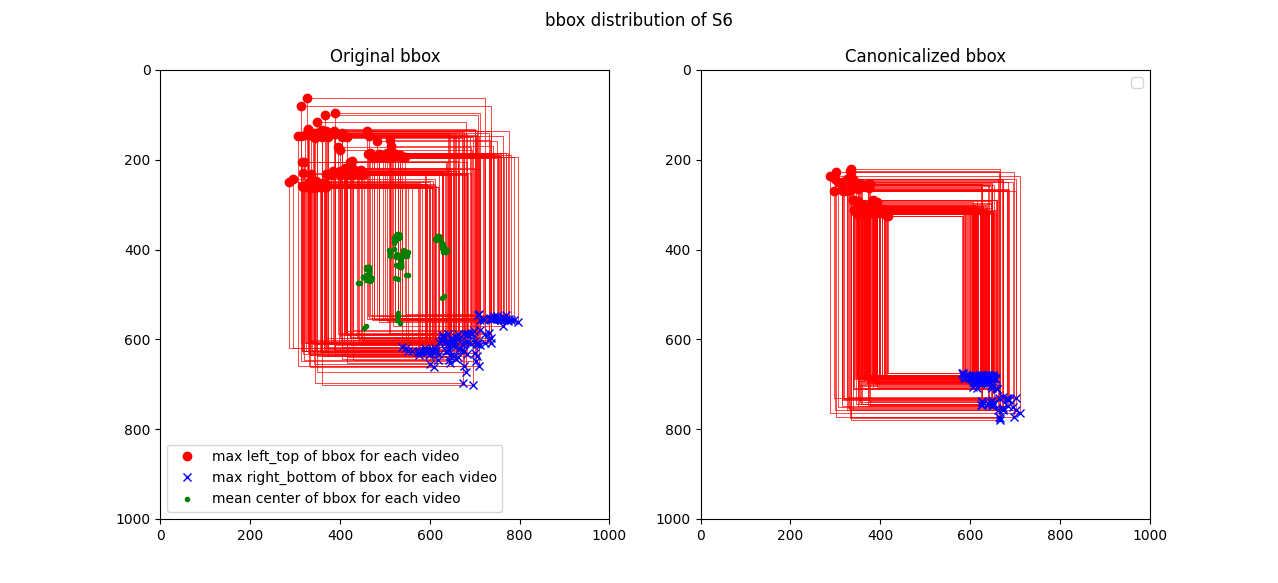

In [95]:
subject = 'S6'

max_left_list = data_dict[subject]['max_left_list']
max_right_list = data_dict[subject]['max_right_list']
max_top_list = data_dict[subject]['max_top_list']
max_bottom_list = data_dict[subject]['max_bottom_list']
mean_center_list = data_dict[subject]['mean_center_list']

fig = plt.figure(1)
fig.clear()
ax = fig.add_subplot(121)

ax.plot(max_left_list, max_top_list, 'ro', label='max left_top of bbox for each video')
ax.plot(max_right_list, max_bottom_list, 'bx', label='max right_bottom of bbox for each video')
ax.plot(mean_center_list[:, 0], mean_center_list[:, 1], 'g.', label='mean center of bbox for each video')
for i in range(len(max_left_list)):
    draw_bbox(ax, [max_left_list[i], max_top_list[i], max_right_list[i], max_bottom_list[i]], color="red", linewidth=0.5)
ax.set_xlim(0, 1000)
ax.set_ylim(1000, 0)
ax.set_aspect('equal')
ax.legend()
ax.set_title('Original bbox')

ax_cano = fig.add_subplot(122)
for i in range(len(max_left_list)):
    center_x = (max_left_list[i] + max_right_list[i])/2
    center_y = (max_top_list[i] + max_bottom_list[i])/2
    max_left_canonical = max_left_list[i]-center_x+500
    max_right_canonical = max_right_list[i]-center_x+500
    max_top_canonical = max_top_list[i]-center_y+500
    max_bottom_canonical = max_bottom_list[i]-center_y+500
    ax_cano.plot(max_left_canonical, max_top_canonical, 'ro')
    ax_cano.plot(max_right_canonical, max_bottom_canonical, 'bx')
    draw_bbox(ax_cano, [max_left_canonical, max_top_canonical, max_right_canonical, max_bottom_canonical], color="red", linewidth=0.5)
ax_cano.set_xlim(0, 1000)
ax_cano.set_ylim(1000, 0)
ax_cano.set_aspect('equal')
ax_cano.legend()
ax_cano.set_title('Canonicalized bbox')

plt.suptitle(f'bbox distribution of {subject}')
plt.show()

### Visualize bbox distribution of multiple subjects

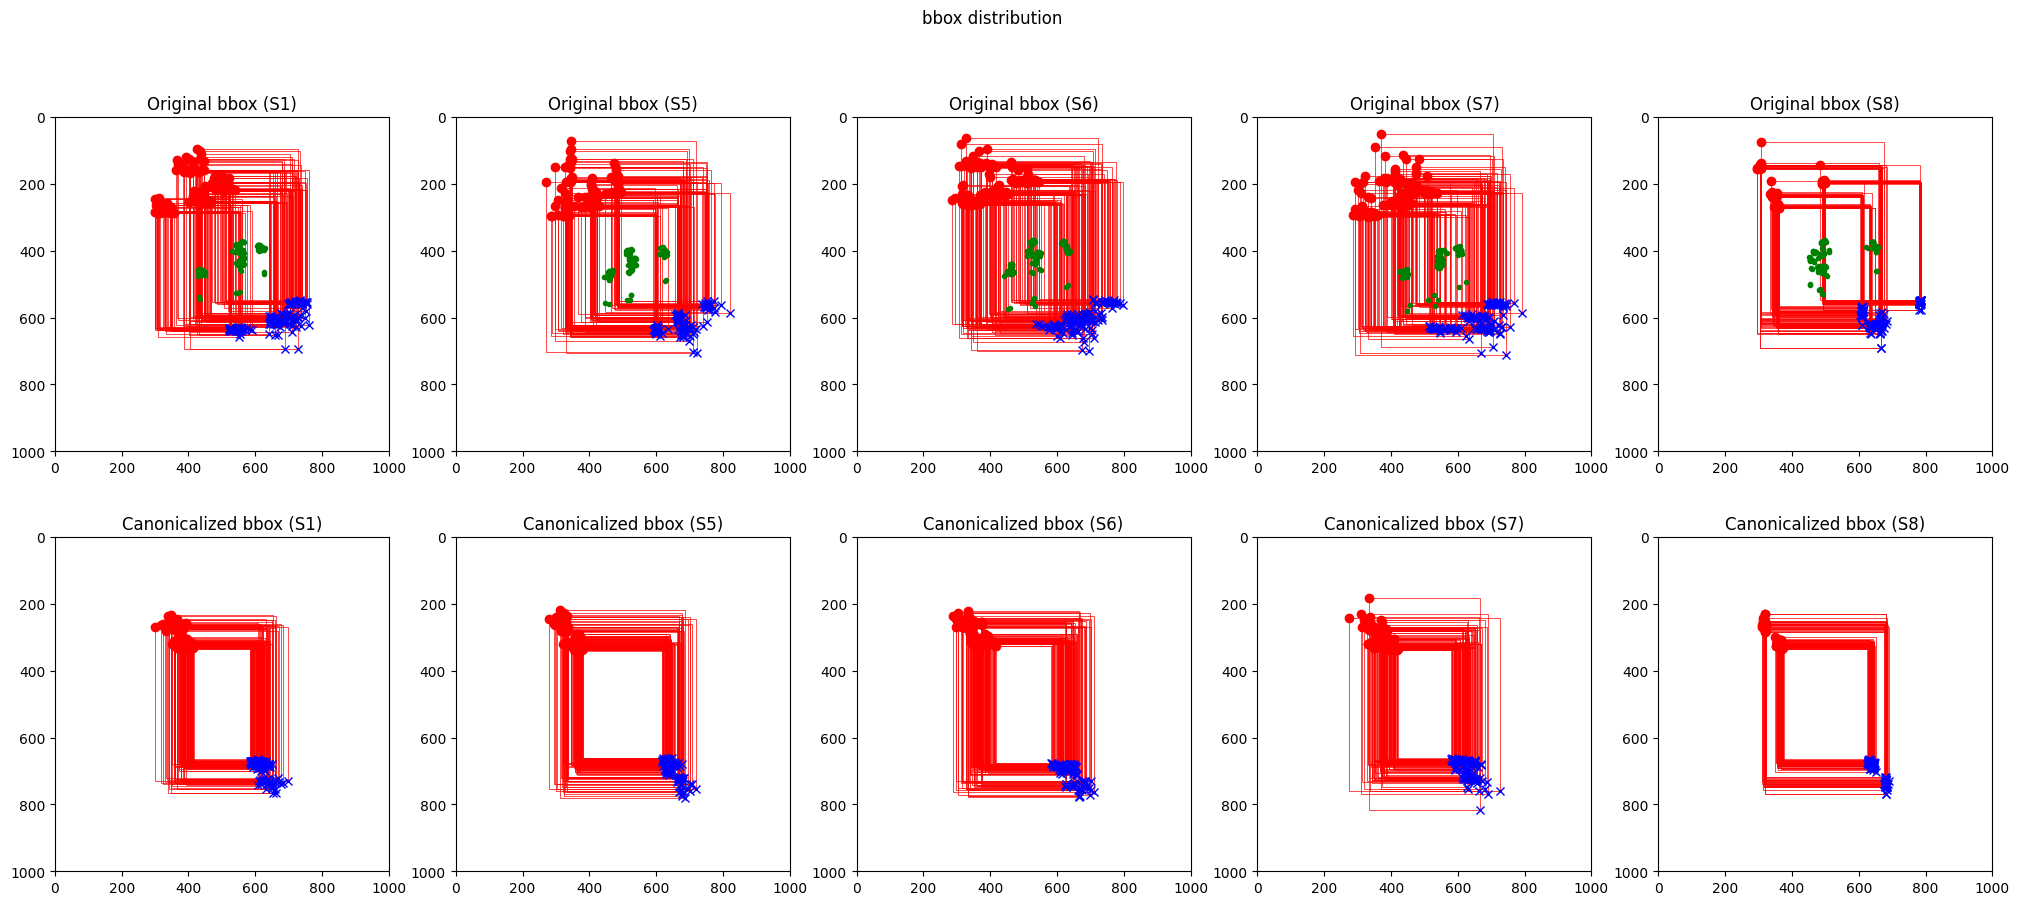

In [116]:
%matplotlib inline
fig, axs = plt.subplots(2, 7, figsize=(25, 10))
for i, ax in enumerate(axs.ravel()):
    ax.set_xlim(0, 1000)
    ax.set_ylim(1000, 0)
    ax.set_aspect('equal')
    if i == 0 or i == 5: subject = 'S1'
    elif i == 1 or i == 6: subject = 'S5'
    elif i == 2 or i == 7: subject = 'S6'
    elif i == 3 or i == 8: subject = 'S7'
    elif i == 4 or i == 9: subject = 'S8'
    if i > 4: canonical = True
    else: canonical = False
    
    max_left_list = data_dict[subject]['max_left_list']
    max_right_list = data_dict[subject]['max_right_list']
    max_top_list = data_dict[subject]['max_top_list']
    max_bottom_list = data_dict[subject]['max_bottom_list']
    mean_center_list = data_dict[subject]['mean_center_list']
    if not canonical:
        ax.plot(max_left_list, max_top_list, 'ro', label='max left_top of bbox for each video')
        ax.plot(max_right_list, max_bottom_list, 'bx', label='max right_bottom of bbox for each video')
        ax.plot(mean_center_list[:, 0], mean_center_list[:, 1], 'g.', label='mean center of bbox for each video')
        for i in range(len(max_left_list)):
            draw_bbox(ax, [max_left_list[i], max_top_list[i], max_right_list[i], max_bottom_list[i]], color="red", linewidth=0.5)
        ax.set_title(f'Original bbox ({subject})')
    else:
        ax.set_title(f'Canonicalized bbox ({subject})')
        for i in range(len(max_left_list)):
            center_x = (max_left_list[i] + max_right_list[i])/2
            center_y = (max_top_list[i] + max_bottom_list[i])/2
            max_left_canonical = max_left_list[i]-center_x+500
            max_right_canonical = max_right_list[i]-center_x+500
            max_top_canonical = max_top_list[i]-center_y+500
            max_bottom_canonical = max_bottom_list[i]-center_y+500
            ax.plot(max_left_canonical, max_top_canonical, 'ro')
            ax.plot(max_right_canonical, max_bottom_canonical, 'bx')
            draw_bbox(ax, [max_left_canonical, max_top_canonical, max_right_canonical, max_bottom_canonical], color="red", linewidth=0.5)

plt.suptitle(f'bbox distribution')
plt.show()
    